In [1]:
import torch
import torchvision.transforms as tfms

from create_paths import smoothen_paths
import os, math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
MAP_NAME = 'map_64x64'

with open(f'./env/{MAP_NAME}/{MAP_NAME}.txt') as file:
    vals = file.readline().rstrip().rsplit(' ')                 # gets string array of [size_x, size_y]
    size_x, size_y = int(vals[0]), int(vals[1])

MAP_DIMS = (size_x,size_y)
START = (10,10)
GOAL = (55,55)
NUM_PATHS = 100

transforms = tfms.Compose(
    [
        tfms.ToTensor(),
        tfms.Normalize([0.5 for _ in range(1)], [0.5 for _ in range(1)])
    ]
)

In [3]:
class PathsDataset(torch.utils.data.Dataset):
    def __init__(self, path, transform=None, shape = (100,100)):
        self.paths = [] # create a list to hold all paths read from file
        for filename in os.listdir(path):
            with open(os.path.join(path, filename), 'r') as f: # open in readonly mode
                self.flat_path = np.loadtxt(f) # load in the flat path from file
                self.path = np.asarray(self.flat_path, dtype=int).reshape(len(self.flat_path)//2,2) #unflatten the path from the file

                self.path_matrix = self.convert_path(shape, self.path)
                
                self.paths.append(self.path_matrix) # add the path to paths list
        self.transform = transform
        print("Done!")

    def convert_path(self, map_dim, path):
        path_mat = np.zeros(map_dim, dtype=float)

        # Make the path continuous
        for i in range(path.shape[0] - 1):
            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            if (x1 < x2):
                x_dir = 1
            else:
                x_dir = -1

            if (y1 < y2):
                y_dir = 1
            else:
                y_dir = -1

            # Determine y from x
            if x2 != x1:
                m = (y2-y1)/(x2-x1)
                while x != x2:
                    y = round(m*(x-x1) + y1)
                    path_mat[y,x] = 1
                    x += x_dir
            else:
                while x != x2:
                    path_mat[y1,x] = 1
                    x += x_dir


            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            # Determine x from y
            if y2 != y1:
                m = (x2-x1)/(y2-y1)
                while y != y2:
                    x = round(m*(y-y1) + x1)
                    path_mat[y,x] = 1
                    y += y_dir
            else:
                while y != y2:
                    path_mat[y,x1] = 1
                    y += y_dir
            
        path_mat[path[path.shape[0]-1,1], path[path.shape[0]-1,0]] = 1     # Include the last point in the path

        return path_mat

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        x = np.float32(self.paths[idx])

        if self.transform:
            x = self.transform(x).cuda()

        return x

In [6]:
# open and unflatten map file:
flat_map = np.loadtxt(f'./env/{MAP_NAME}/{MAP_NAME}.txt', skiprows=2)             
map = np.asarray(flat_map).reshape(MAP_DIMS[0], MAP_DIMS[1])

In [7]:
# open and unflatten path files:
paths = []
for i in range(NUM_PATHS):
    flat_path = np.loadtxt(f'./env/{MAP_NAME}/paths/vegan_paths/path_{i}_.txt', delimiter=',')             
    path = np.asarray(flat_path)
    paths.append(path)

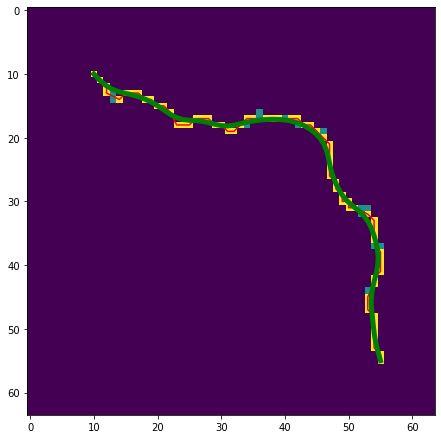

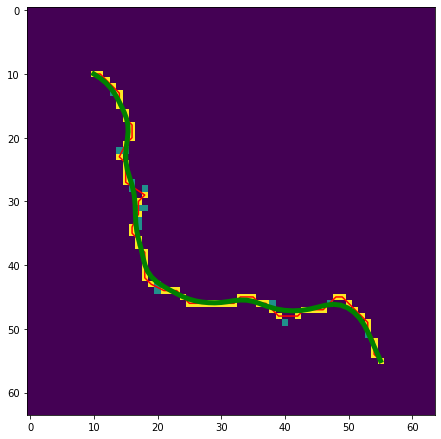

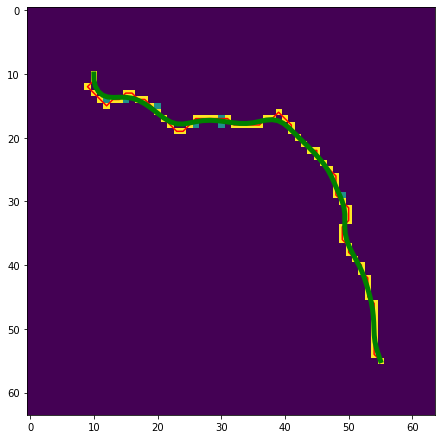

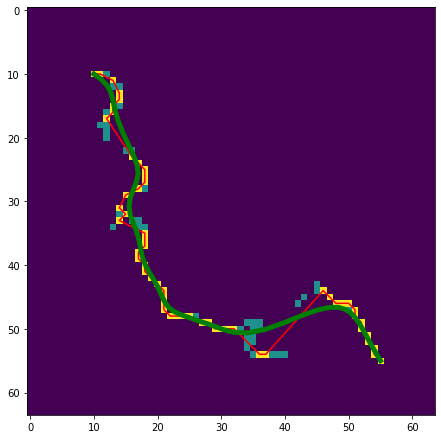

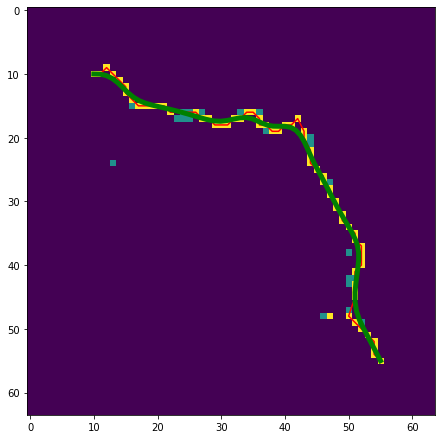

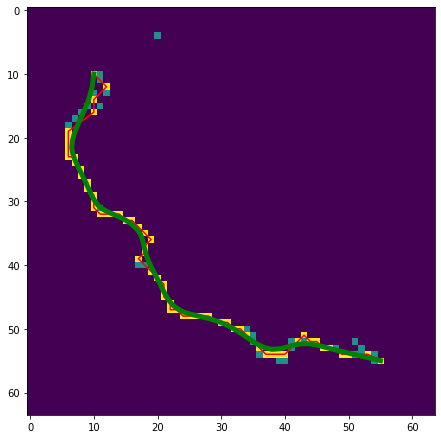

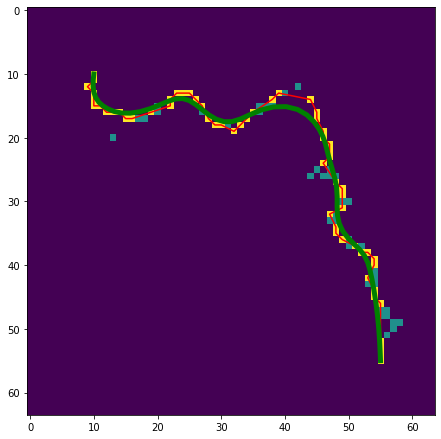

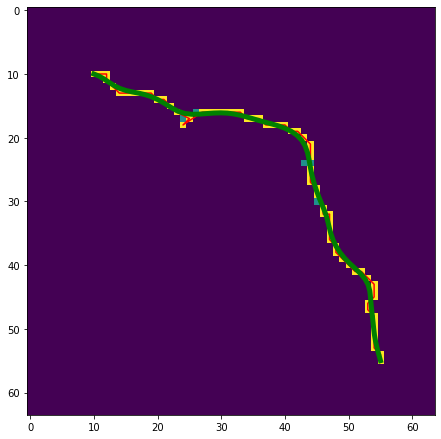

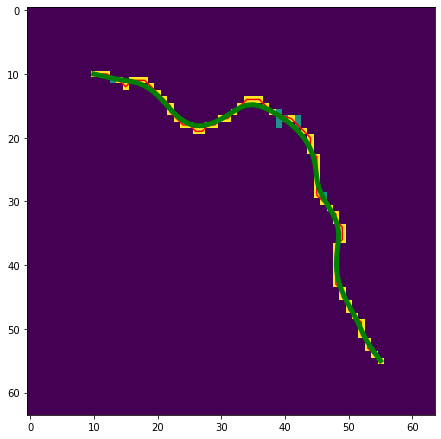

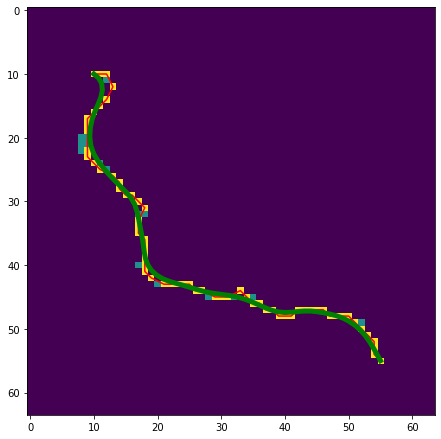

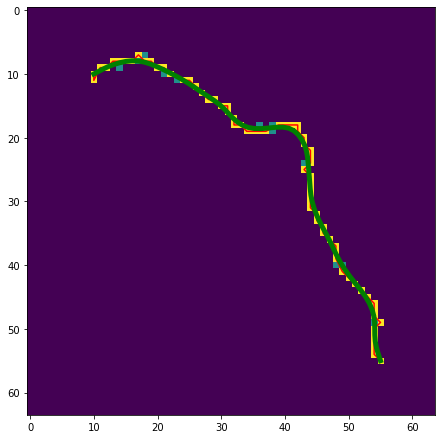

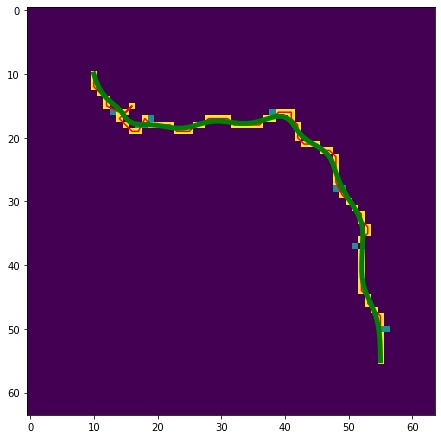

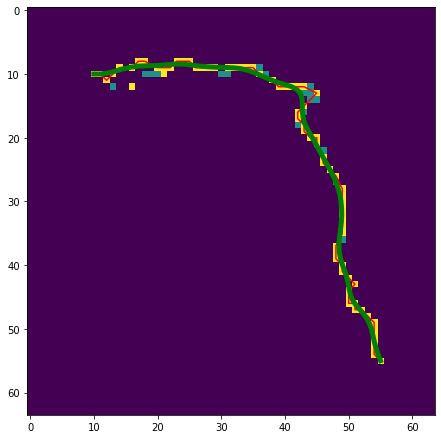

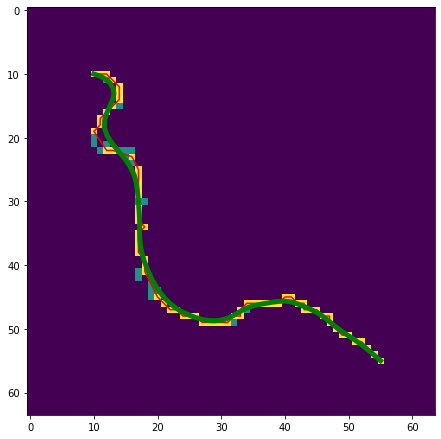

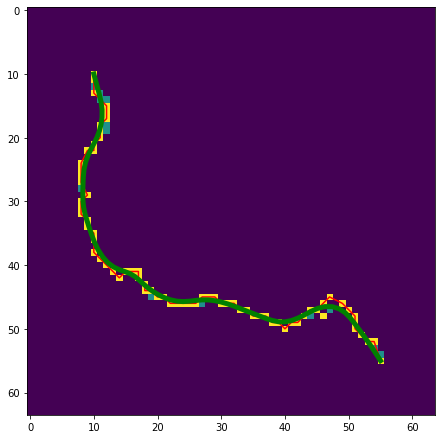

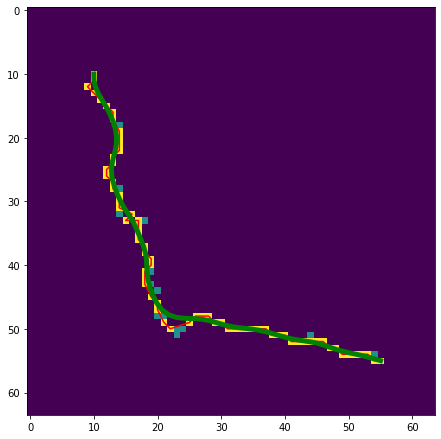

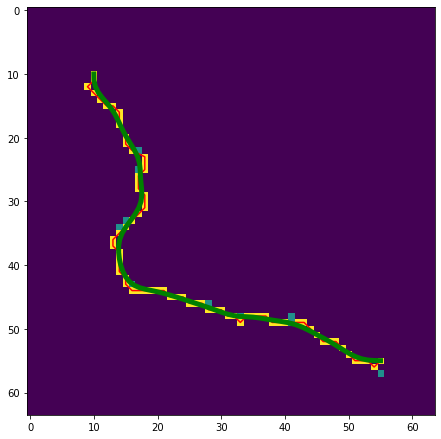

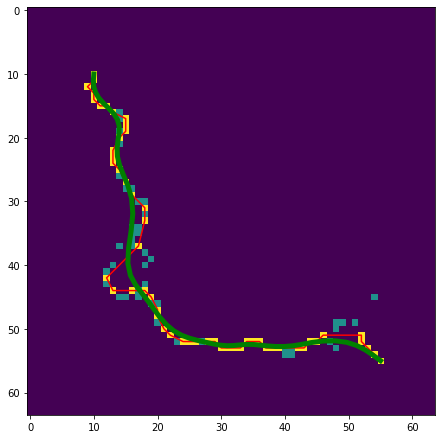

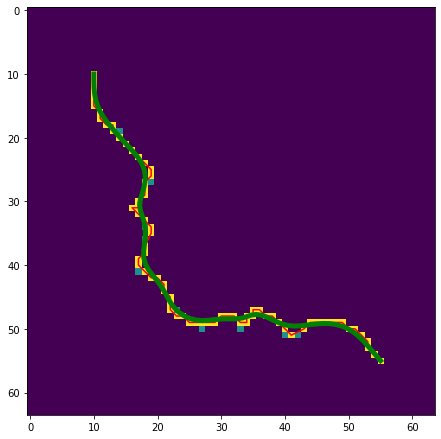

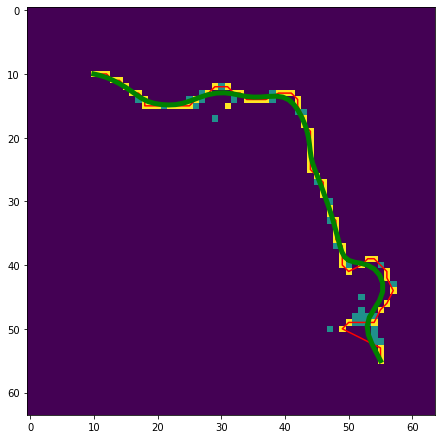

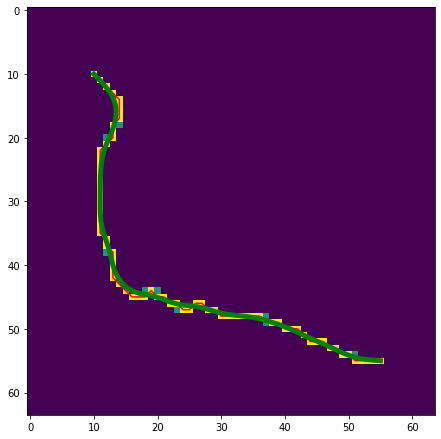

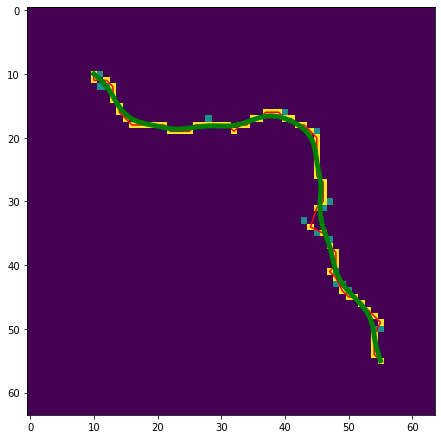

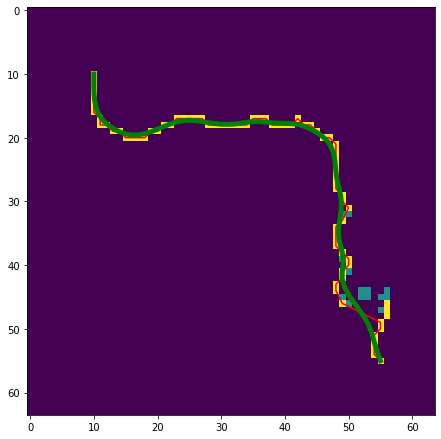

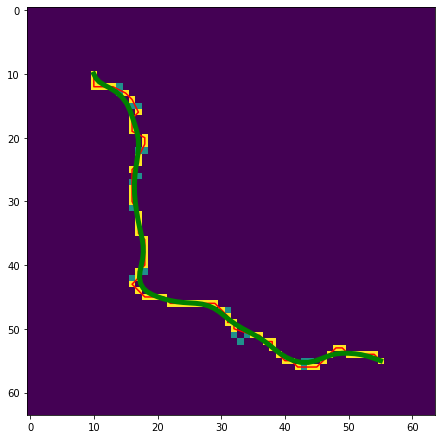

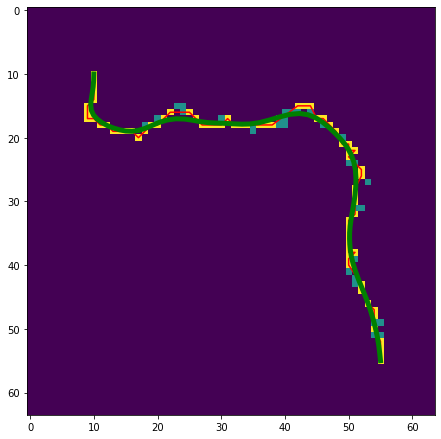

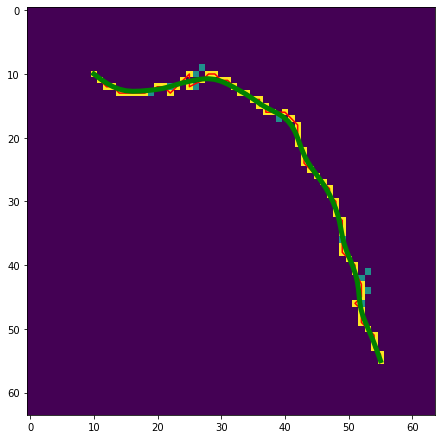

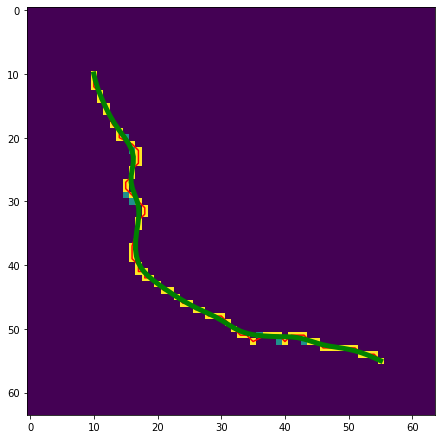

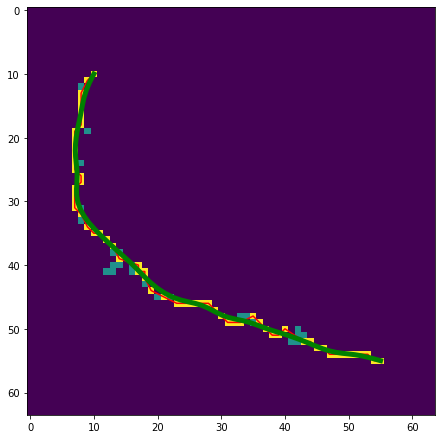

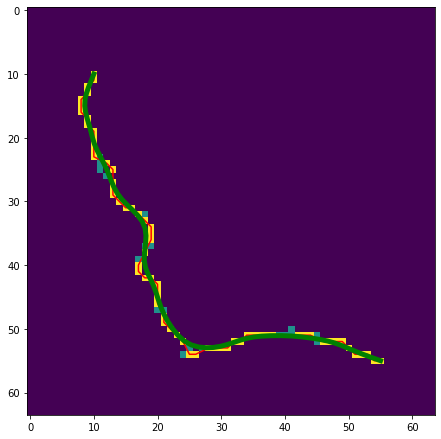

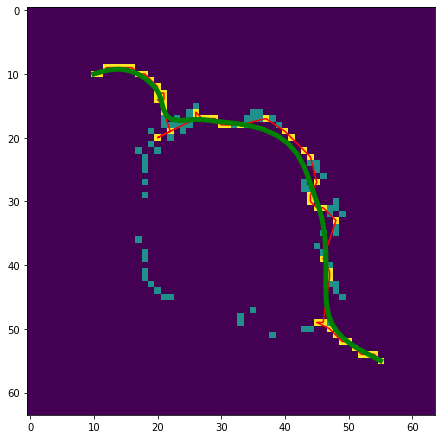

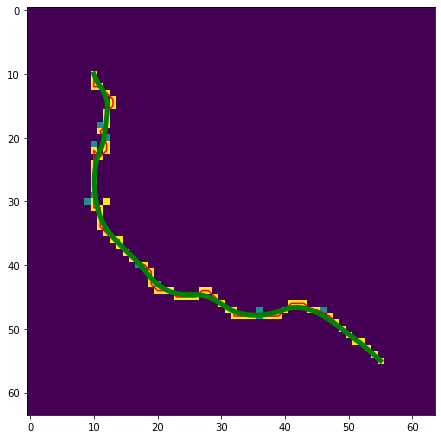

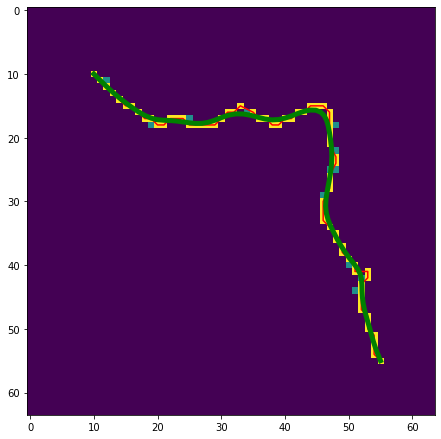

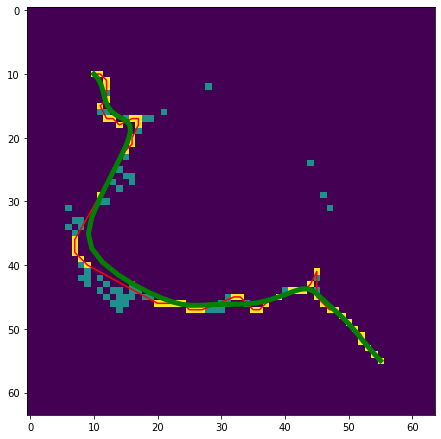

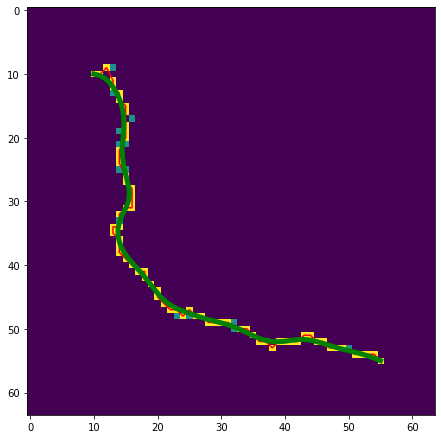

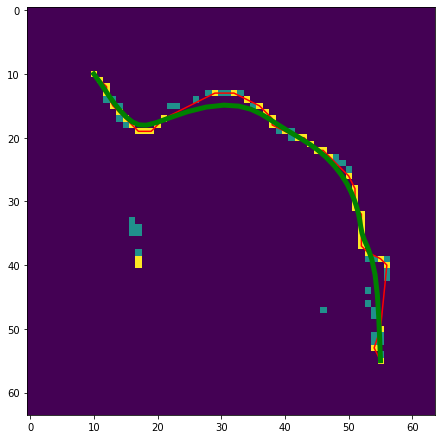

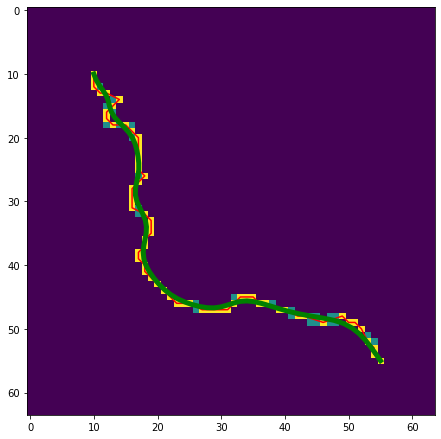

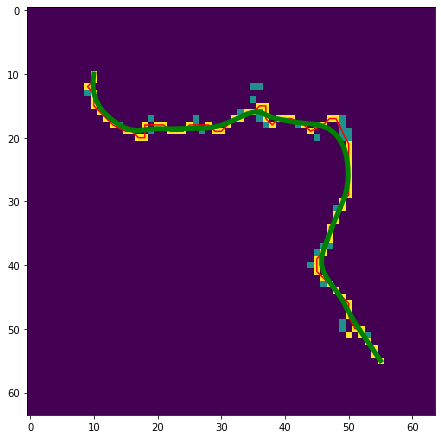

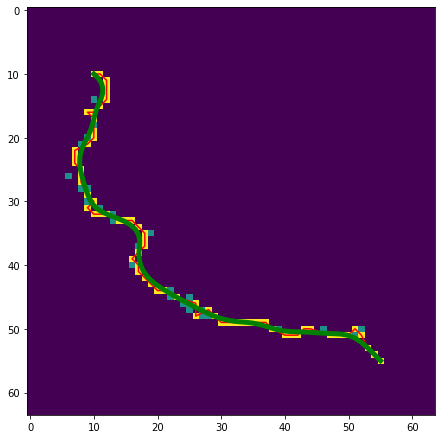

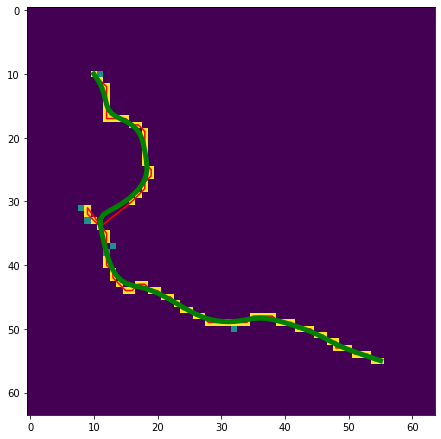

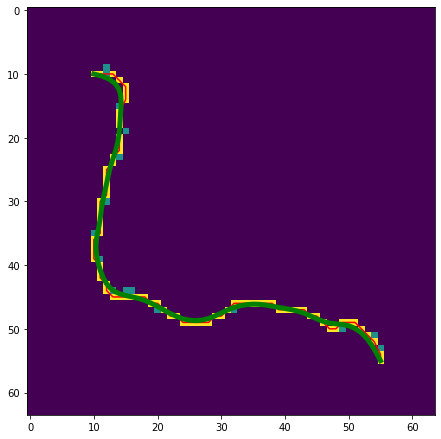

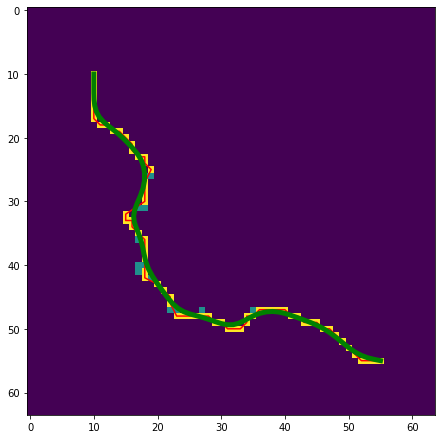

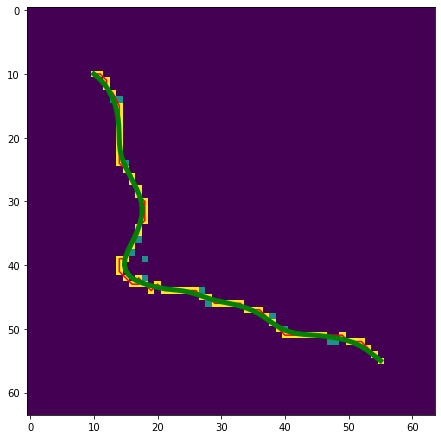

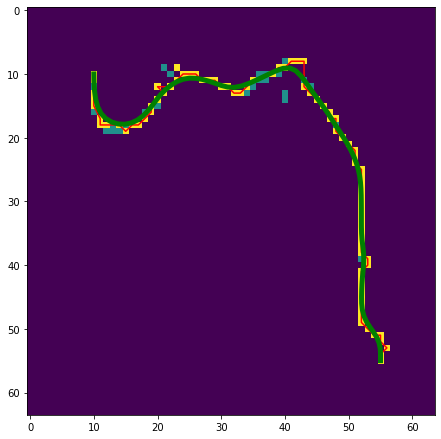

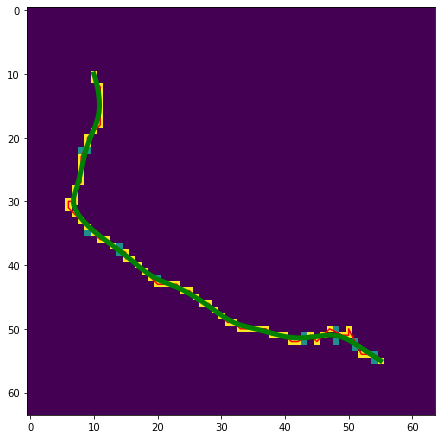

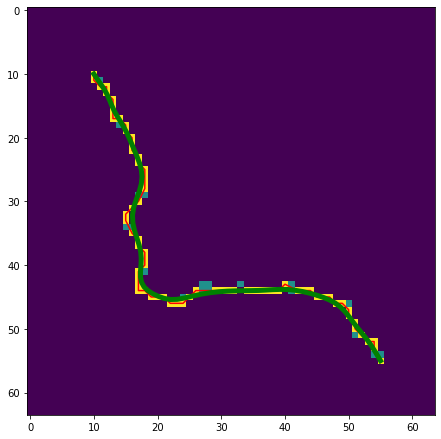

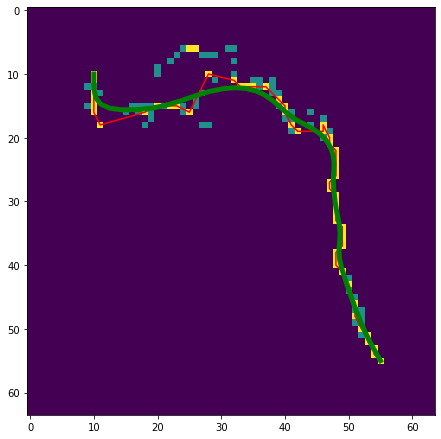

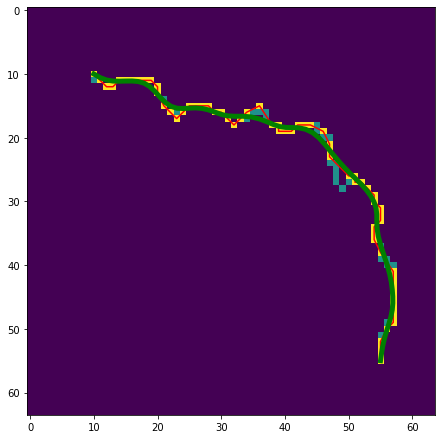

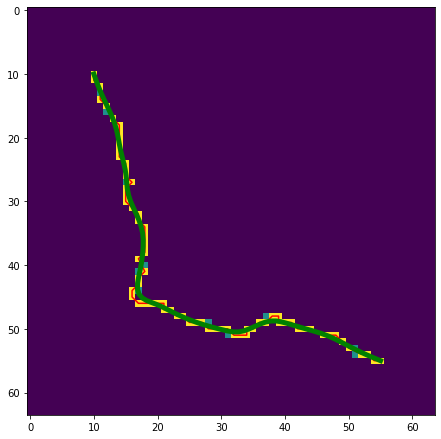

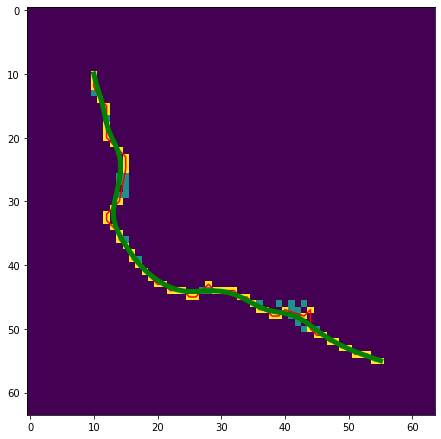

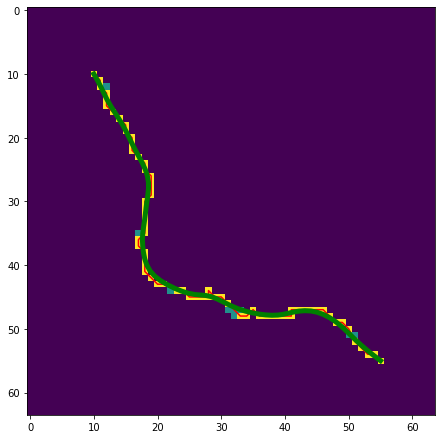

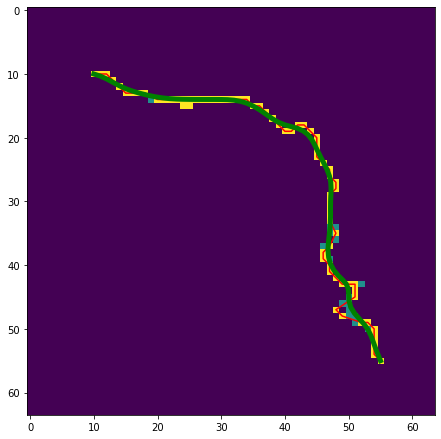

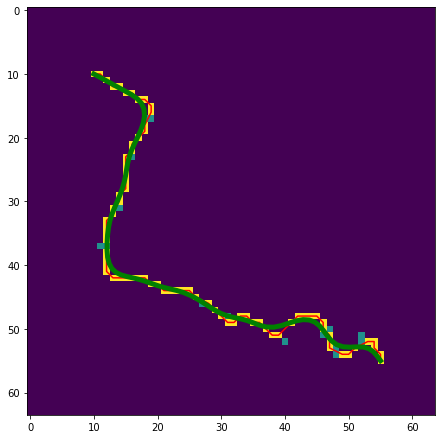

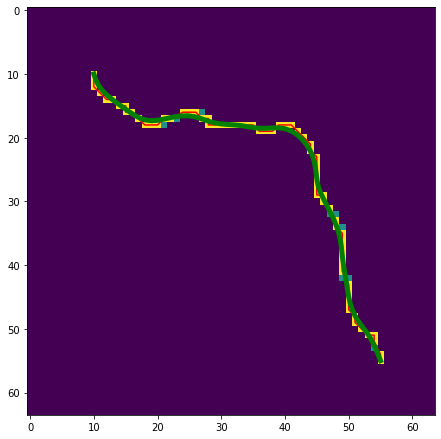

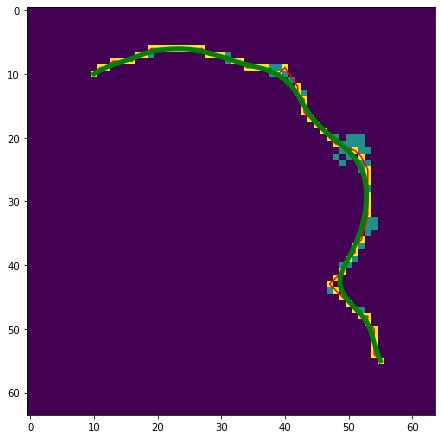

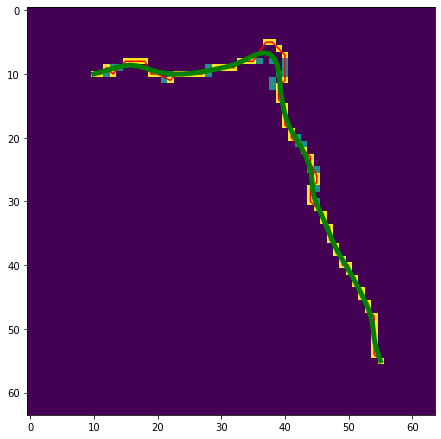

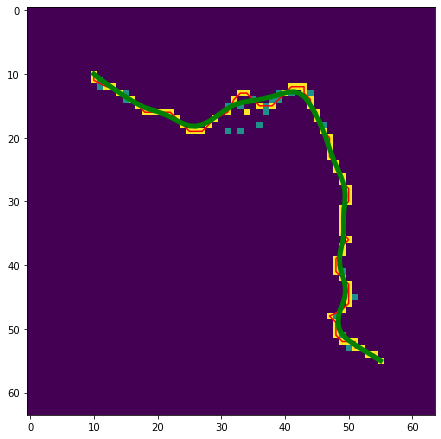

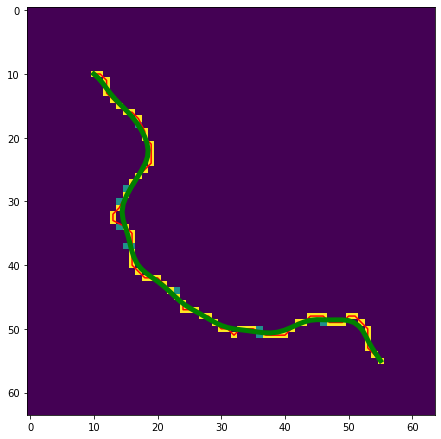

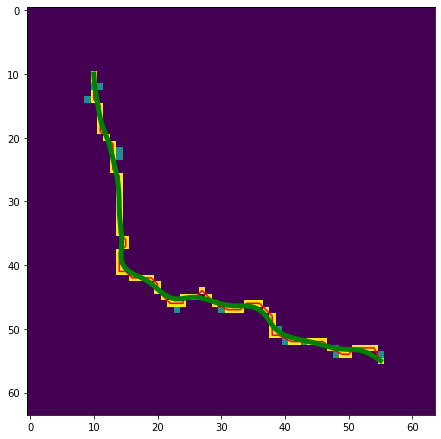

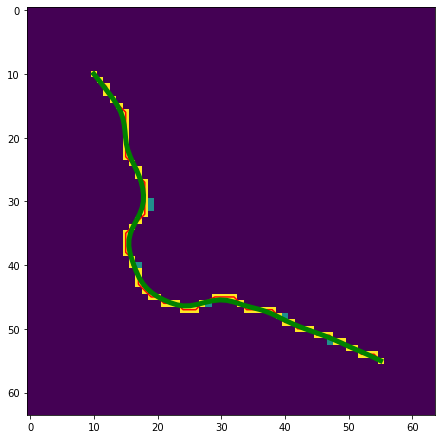

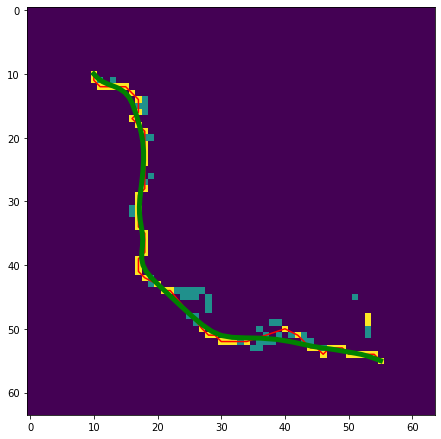

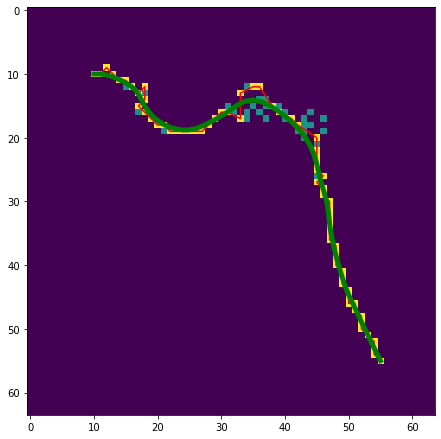

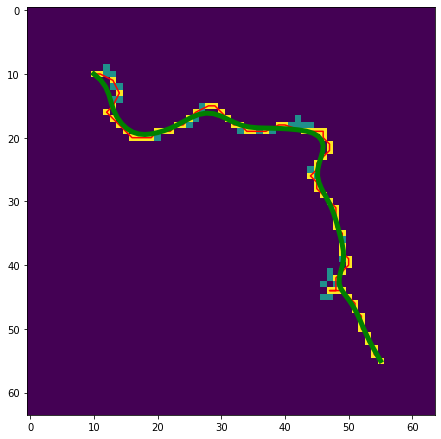

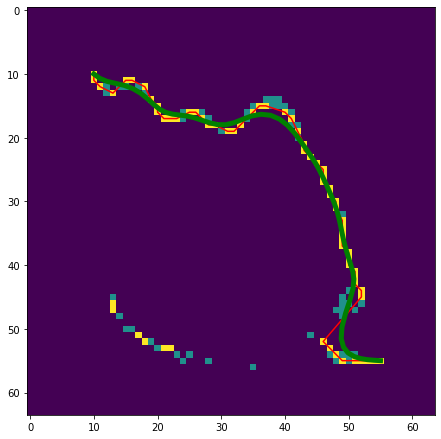

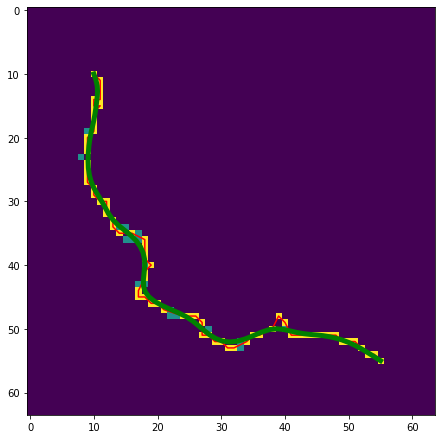

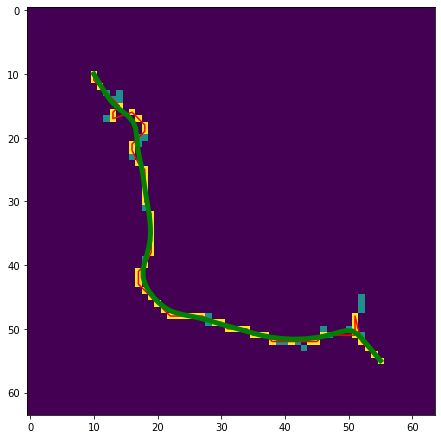

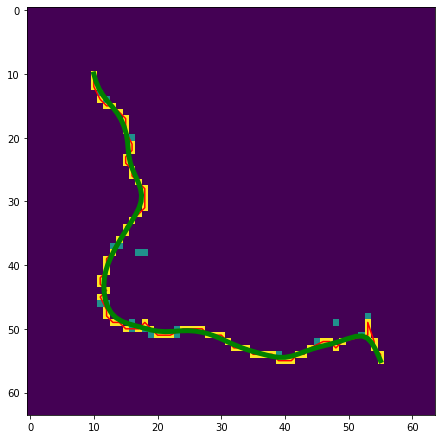

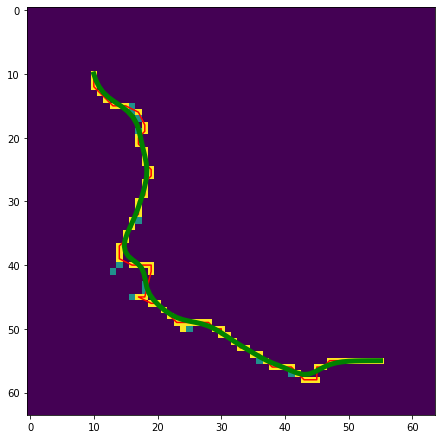

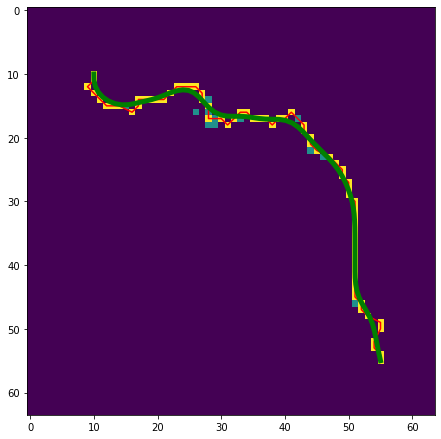

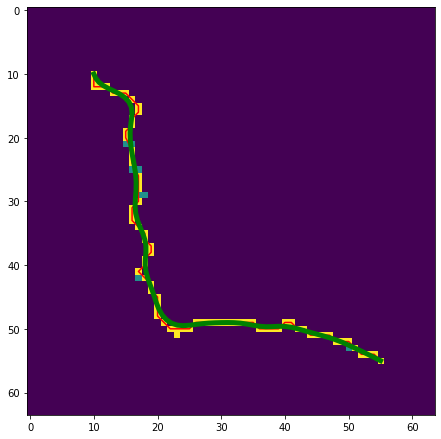

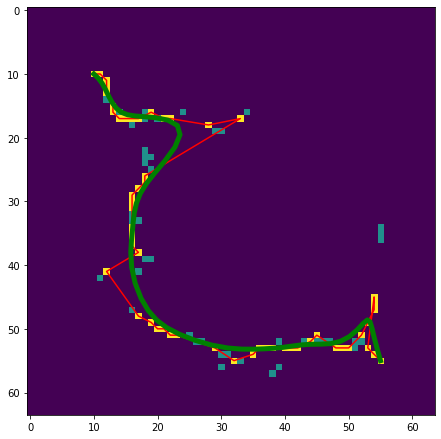

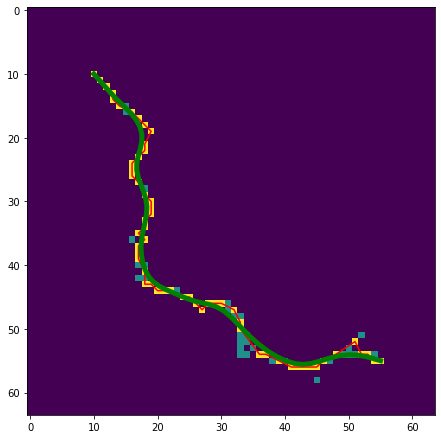

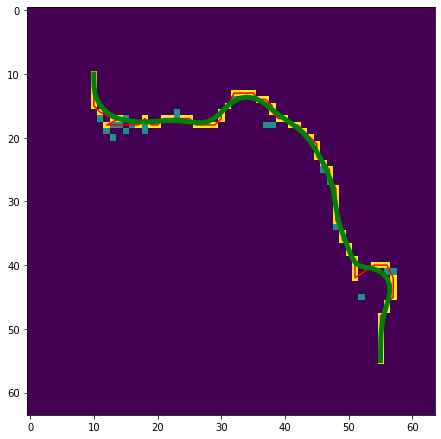

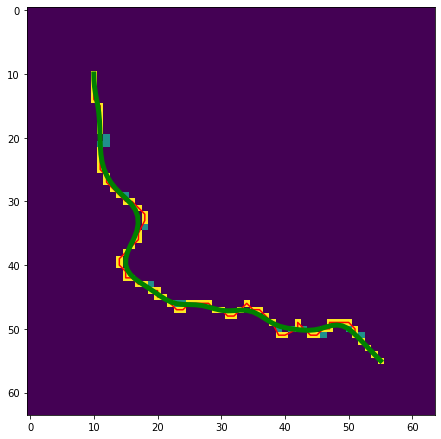

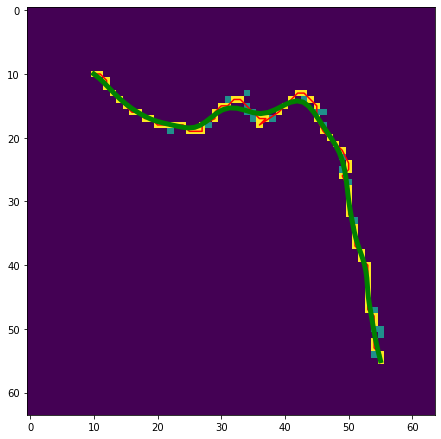

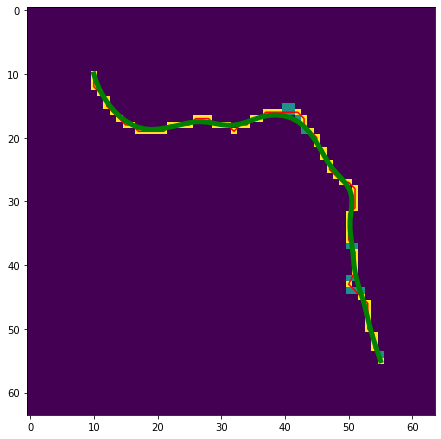

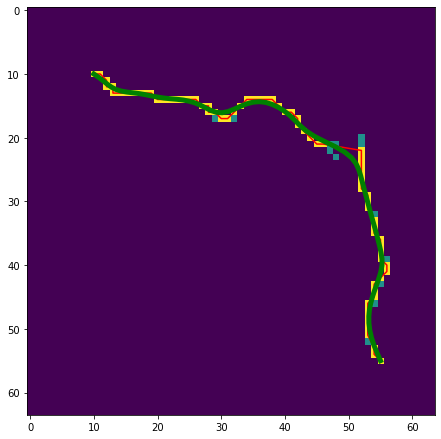

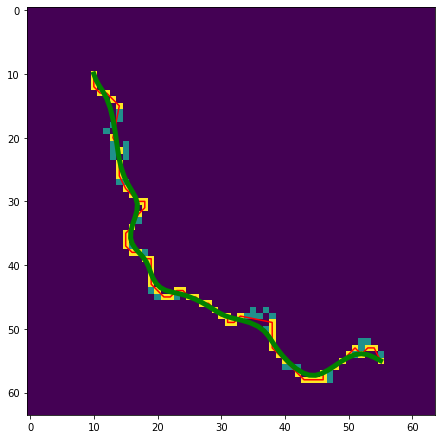

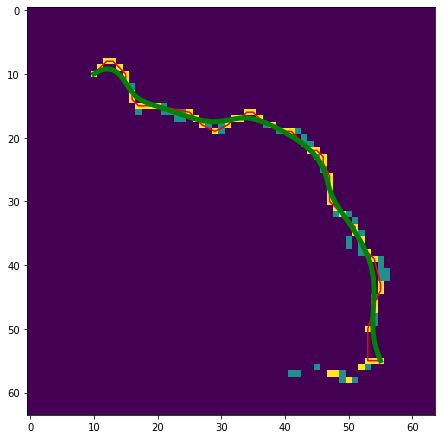

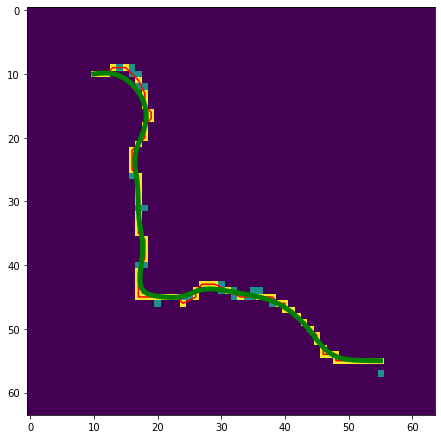

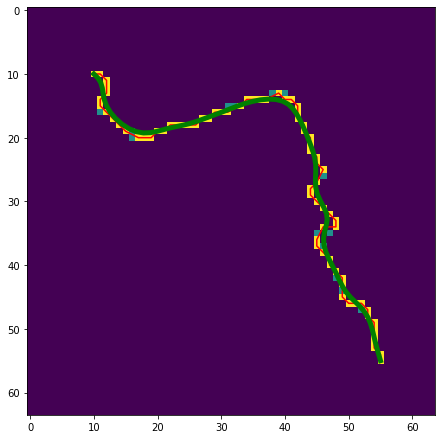

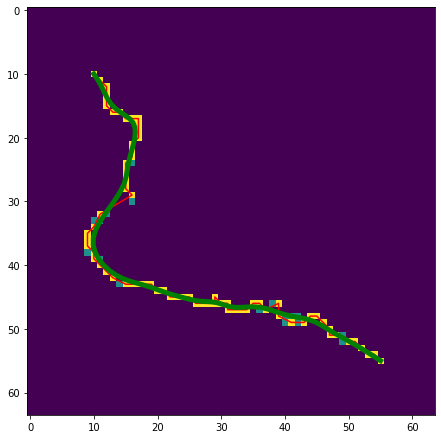

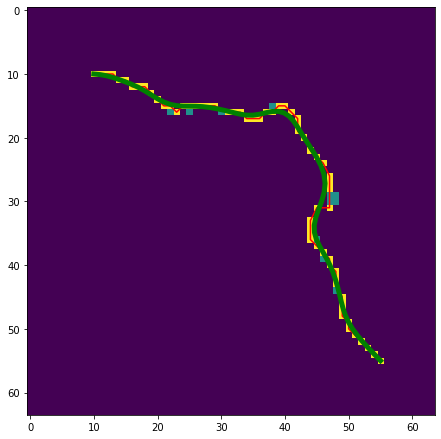

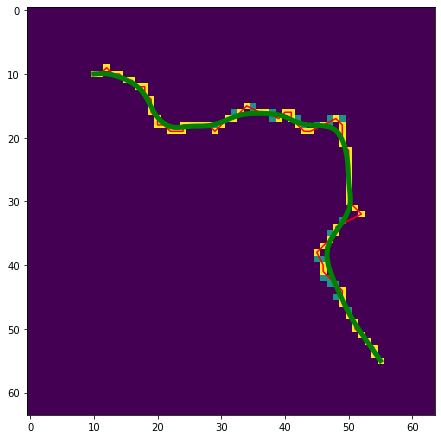

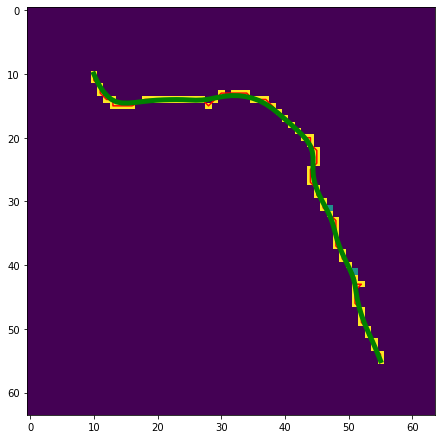

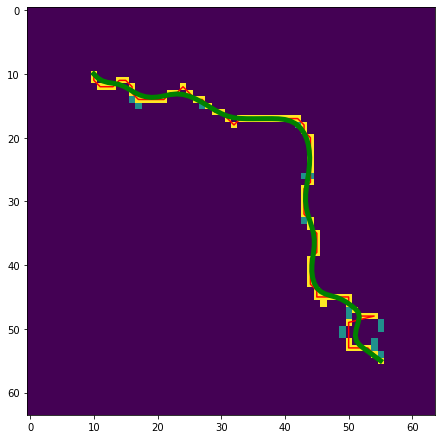

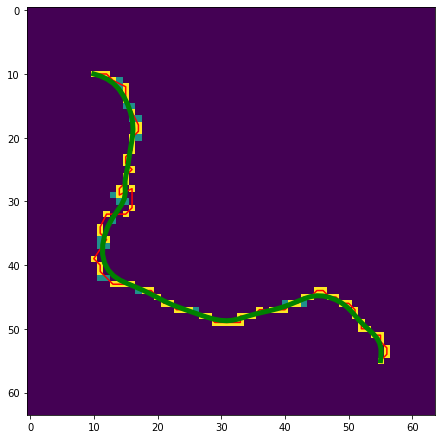

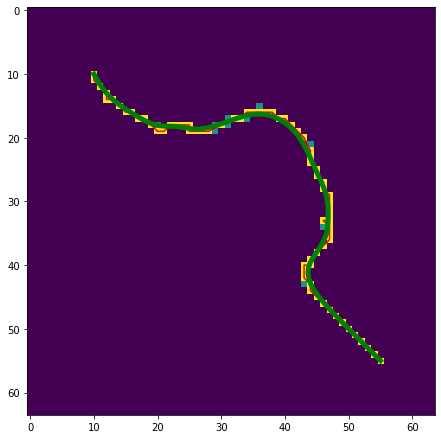

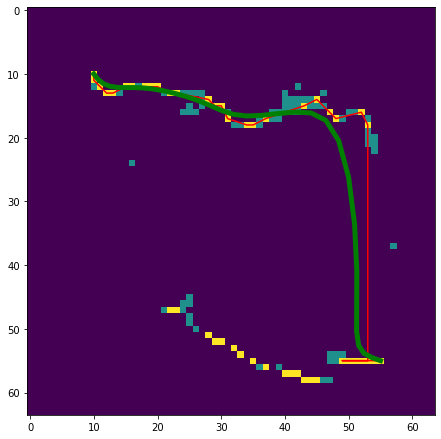

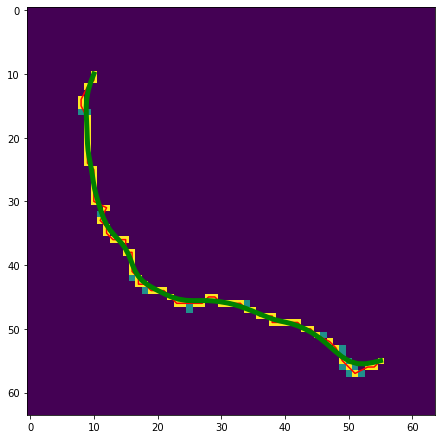

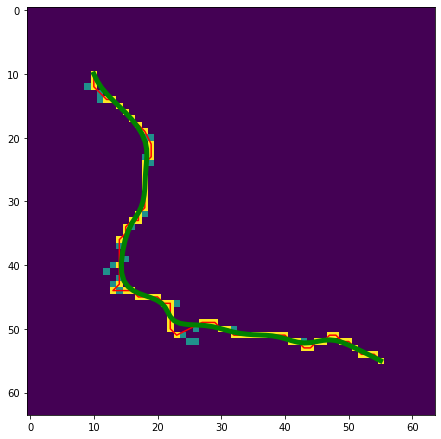

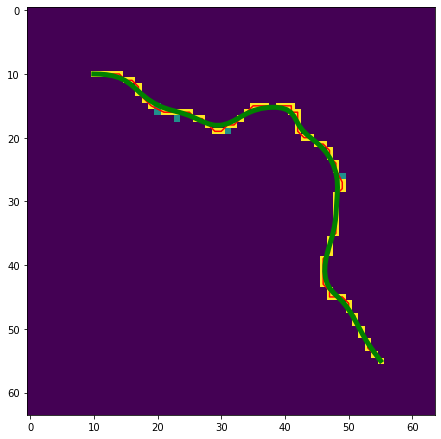

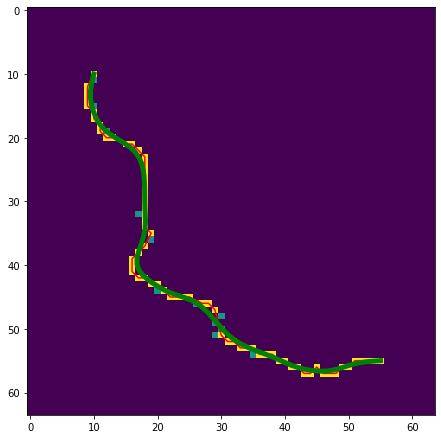

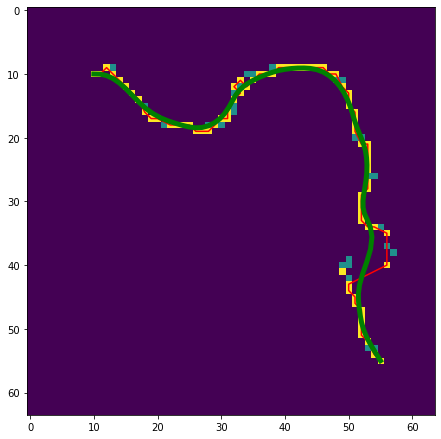

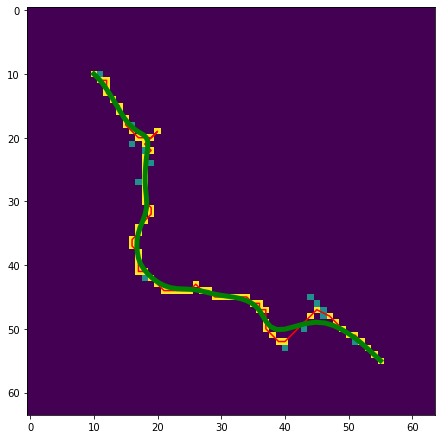

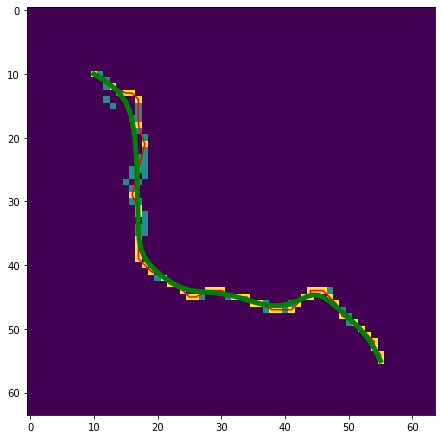

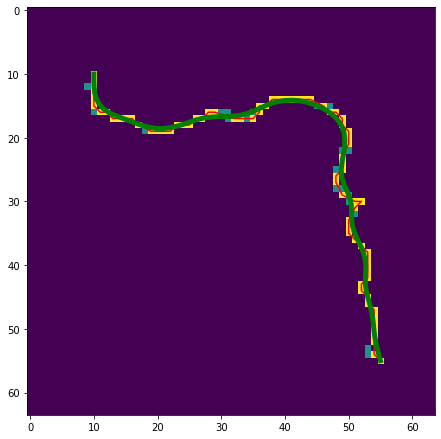

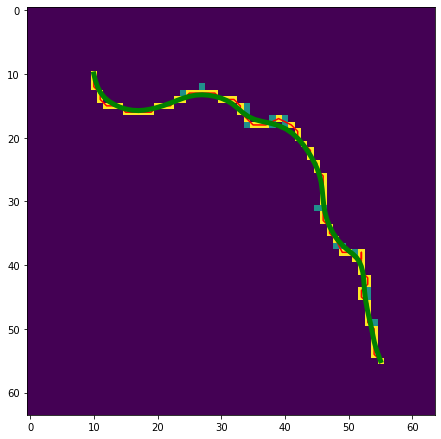

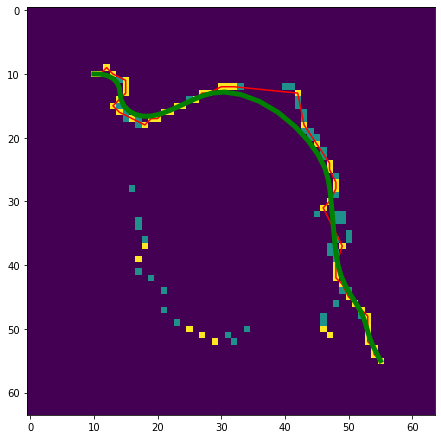

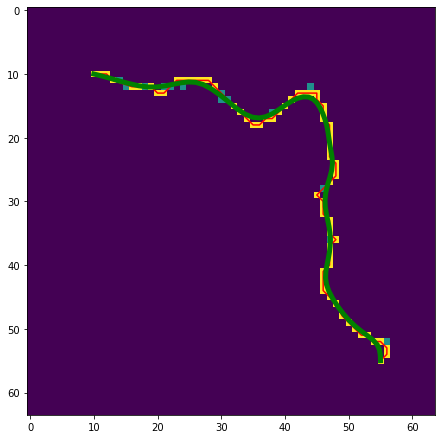

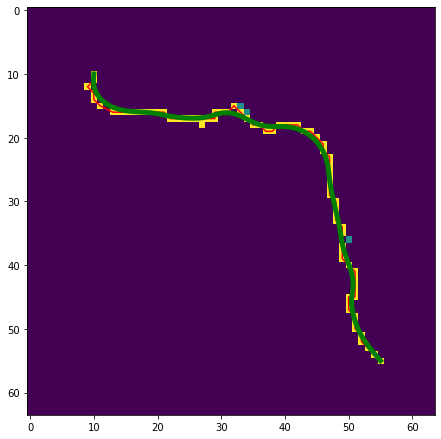

In [9]:
# smoothening and saving loaded paths:
smoothen_paths(paths, START, GOAL)